In [43]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

QUADRATIC AND LINEAR
 FUNCTIONS ON EXAMPLES.PY

In [59]:
class Linear_Quadratic_Function:
    def __init__(self, q2=None, q1=None, q0=0):
        self.q0 = q0
        if q2 is None:
            # linear function
            self.q1 = np.array(q1).reshape(-1, 1)
            self.dim = self.q1.shape[0]
            self.q2 = np.zeros(shape=(self.dim, self.dim))
        elif q1 is None:
            # quadratic function without linear term
            self.q2 = np.array(q2)
            self.dim = q2.shape[0]
            self.q1 = np.zeros(shape=(self.dim, 1))
        else:
            self.q1 = np.array(q1).reshape(-1, 1)
            self.dim = len(q1)
            self.q2 = np.array(q2)
        self.hessian = self.q2 + self.q2.T
        
    def __call__(self, x, calc_gradient=True, calc_hessian=False):
        # x might be a matrix of vertical vectors of (x1,x2)
        # f = (x.T.dot(self.q2).dot(x) + self.q1.T.dot(x) + self.q0).item()
        f = np.einsum("ij,ji->i", x.T.dot(self.q2), x) + self.q1.T.dot(x) + self.q0
        if f.size == 1:
            f = f.item()
        if not calc_gradient:
            return f
        g = self.hessian.dot(x) + self.q1
        h = self.hessian if calc_hessian else None
        return f, g, h


quad_func1 = Linear_Quadratic_Function(q2=np.array([[1, 0], [0, 1]], dtype=float))
q1_1000 = np.array([[1, 0], [0, 1000]], dtype=float)
quad_func2 = Linear_Quadratic_Function(q2=q1_1000)
q_rotate = np.array([[math.sqrt(3) / 2, -0.5], [0.5, math.sqrt(3) / 2]], dtype=float)
quad_func3 = Linear_Quadratic_Function(q2=q_rotate.T.dot(q1_1000).dot(q_rotate))

linear_function = Linear_Quadratic_Function(q1=[1, 1])


def rosenbrock(x, calc_gradient=True, calc_hessian=False):
    # x might be a matrix of vertical vectors of (x1,x2)
    x1, x2 = x[0], x[1]
    f = 100 * (x2 - x1 * x1) ** 2 + (1 - x1) ** 2
    if f.size == 1:
        f = f.item()
    if not calc_gradient:
        return f
    g = np.vstack([400 * x1 ** 3 - 400 * x1 * x2 + 2 * x1 - 2, 200 * (x2 - x1 * x1)])
    assert g.shape == x.shape
    if calc_hessian and x.shape[1] == 1:
        x1, x2 = x1.item(), x2.item()
        h = np.array([[1200 * x1 * x1 - 400 * x2 + 2, -400 * x1], [-400 * x1, 200]], dtype=float)
    else:
        h = None
    return f, g, h


def boyd(x, calc_gradient=True, calc_hessian=False):
    # x might be a matrix of vertical vectors of (x1,x2)
    x1, x2 = x[0], x[1]
    f1 = np.exp(x1 + 3 * x2 - 0.1)
    f2 = np.exp(x1 - 3 * x2 - 0.1)
    f3 = np.exp(-x1 - 0.1)
    f = f1 + f2 + f3
    if f.size == 1:
        f = f.item()
    if not calc_gradient:
        return f
    g2 = 3 * f1 - 3 * f2
    g = np.vstack([f1 + f2 - f3, g2])
    assert g.shape == x.shape
    if calc_hessian and x.shape[1] == 1:
        f1 = f1.item()
        f2 = f2.item()
        g2 = g2.item()
        h = np.array([[f, g2], [g2, 9 * f1 + 9 * f2]])
    else:
        h = None
    return f, g, h


In [60]:
class Lagrangian:
    def __init__(self, f, is_minimize, A=None, b=None, inequalities=None, t=1):
        for x_dim in range(1, 1000):
            try:
                f(np.zeros(shape=(x_dim, 1)), calc_gradient=False)
                self.x_dim = x_dim
                break
            except ValueError:
                pass
        self.f = f
        if (isinstance(A, np.ndarray) and A.size > 0) or (isinstance(A, list) and A):
            self.equality_constrains = True
            self.A = np.array(A)
            self.b = np.array(b).reshape(-1, 1)
            self.nu_dim = self.b.shape[0]  # number of equality constraints
            assert self.A.shape == (self.nu_dim, self.x_dim)
        else:
            self.equality_constrains = False
            self.nu_dim = 0
        self.nu_hessian = np.zeros(shape=(self.nu_dim, self.nu_dim))
        if isinstance(inequalities, list) and inequalities:
            self.inequalities = inequalities
            self.t = float(t)
        else:
            self.inequalities = []
            self.t = 1.0
        self.is_minimize = 1 if is_minimize else -1

    def __call__(self, x, calc_gradient=True, calc_hessian=False):
        x, mu = x[:self.x_dim], x[self.x_dim:]
        f_res = self.f(x, calc_gradient, calc_hessian)
        factor = self.t * self.is_minimize
        lagrange_f = factor * (f_res[0] if calc_gradient else f_res)
        if self.equality_constrains:
            lagrange_f += mu.T.dot(self.A.dot(x) - self.b).reshape(-1)
        inequalities_res = [ineq(x, calc_gradient, calc_hessian) for ineq in self.inequalities]
        if not calc_gradient:
            if inequalities_res:
                inequalities_f = np.array(inequalities_res)
                if inequalities_f.max() > -np.finfo(float).eps:
                    return np.inf
                lagrange_f -= np.log(-inequalities_f).sum()
            return lagrange_f
        lagrange_g = factor * f_res[1]
        lagrange_h = factor * f_res[2] if calc_hessian else None
        if inequalities_res:
            inequalities_f = np.array([ineq[0] for ineq in inequalities_res])
            if inequalities_f.max() > -np.finfo(float).eps:
                return np.inf, None, None
            inequalities_g = np.hstack([ineq[1] for ineq in inequalities_res]) / inequalities_f
            if calc_hessian:
                inequalities_hh = np.sum(
                    np.array([ineq[2] for ineq in inequalities_res]) / inequalities_f.reshape((-1, 1, 1)), axis=0)
                inequalities_hg = np.einsum("ij,kj->ik", inequalities_g, inequalities_g)  # sum (g*g.T)
                inequalities_h = inequalities_hh - inequalities_hg
                lagrange_h -= inequalities_h
            lagrange_g -= np.sum(inequalities_g, axis=1).reshape(-1, 1)
            lagrange_f -= np.log(-inequalities_f).sum()

        if self.equality_constrains:
            lagrange_g = np.vstack([lagrange_g + self.A.T.dot(nu), self.A.dot(x) - self.b])
            if calc_hessian:
                lagrange_h = np.vstack([np.hstack([lagrange_h, self.A.T]), np.hstack([self.A, self.nu_hessian])])
        if isinstance(lagrange_f, np.ndarray):
            if len(lagrange_f) == 1:
                lagrange_f = lagrange_f.item()
        elif isinstance(lagrange_f, list):
            if len(lagrange_f) == 1:
                lagrange_f = lagrange_f[0]
        return lagrange_f, lagrange_g, lagrange_h

    def f_inner(self, x_nu):
        assert len(x_nu) >= self.x_dim
        return self.is_minimize * self.f(x_nu[:self.x_dim], calc_gradient=False)

    def obj_tol(self):
        return len(self.inequalities) / self.t

    def get_x0(self, x0):
        return np.vstack([np.array(x0).reshape(-1, 1), np.zeros(shape=(self.nu_dim, 1))])

    def eq_total_norm(self, x_nu):
        if not self.equality_constrains:
            return 0
        assert len(x_nu) >= self.x_dim
        return np.linalg.norm(self.A.dot(x_nu[:self.x_dim]) - self.b)

    def eq_constrains_values(self, x_nu):
        if not self.equality_constrains:
            return []
        assert len(x_nu) >= self.x_dim
        return list((self.A.dot(x_nu[:self.x_dim]) - self.b).reshape(-1))

    def ineq_constrains_values(self, x_nu):
        assert len(x_nu) >= self.x_dim
        return [ineq(x_nu[:self.x_dim], calc_gradient=False) for ineq in self.inequalities]

    def feasible_points(self, points, eps):
        res = np.full(fill_value=True, shape=(points.shape[1],))
        for ineq in self.inequalities:
            val = ineq(points, calc_gradient=False).reshape(-1)
            res &= val < eps
        return res


class MinimizerLoopTracker:
    def __init__(self, obj_tol, param_tol, verbose, print_every, max_iter, location_dim=None, is_minimize=True):
        self.objective_values = []
        self.location_values = []
        self.obj_tol = obj_tol
        self.param_tol2 = param_tol * param_tol
        self.verbose = verbose
        self.print_every = print_every
        self.max_iter = max_iter
        self.success = False
        self.nu_values = None
        self.location_dim = location_dim
        self.is_minimize = is_minimize

    def append(self, f_val, location):
        if not self.objective_values:
            self.location_values = [location.copy()]
            self.objective_values = [f_val]
            if self.verbose and (self.print_every == 1):
                print("Iter[0]: objective={} location: {}".format(self.objective_values[-1],self.location_values[-1].reshape(-1)))
            return True
        objective_improvement = self.objective_values[-1] - f_val
        if objective_improvement > 0:
            loop_iter = len(self.objective_values)
            self.objective_values.append(f_val)
            self.location_values.append(location.copy())
            if self.verbose and ((loop_iter % self.print_every == 0) or (loop_iter == self.max_iter)):
                print("Iter[{}]: objective={} location: {}".format(loop_iter, self.objective_values[-1],self.location_values[-1].reshape(-1)))
        if objective_improvement < self.obj_tol:
            self.success = True
            if self.verbose:
                print("Optimization reached the target of objective function.")
            return False
        p_step = location - self.location_values[-2]
        if p_step.T.dot(p_step).item() < self.param_tol2:
            self.success = True
            if self.verbose:
                print("Optimization reached the target of location coordinates.")
            return False
        return True

    def summary(self):
        self.objective_values = np.array(self.objective_values)
        if not self.is_minimize:
            self.objective_values *= -1
        self.location_values = np.hstack(self.location_values)
        res = {'objective': self.objective_values[-1],'success': self.success,'num_iter': len(self.objective_values) - 1}
        if self.location_dim is not None:
            self.nu_values = self.location_values[self.location_dim:]
            self.location_values = self.location_values[:self.location_dim]
            res['final_mu'] = self.nu_values[:, -1].reshape(-1) if self.nu_values.size > 0 else None
            res['dim'] = self.location_dim
        else:
            res['dim'] = self.location_values.shape[0]
        res['location'] = self.location_values[:, -1].reshape(-1)
        norms2 = np.einsum("ij,ij->j", self.location_values, self.location_values)
        res['max_norm_location'] = math.sqrt(max(norms2))
        res['min_objective_value'] = self.objective_values.min()
        res['max_objective_value'] = self.objective_values.max()
        return self.objective_values, self.location_values, res


class LineSearch:
    eps = np.finfo(float).eps
    max_cond = 1 / np.finfo(float).eps

    def __init__(self, step_len=0.1, obj_tol=1e-12, param_tol=1e-8, max_iter=100, newton=True, wolfe_c1=0.0,wolfe_backtracking=0.5, verbose=True, print_every=5, max_iter_outer_lagrangian=100, mu_lagrangian=10,t0_lagrangian=1):
        self.step_len = step_len
        self.obj_tol = obj_tol
        self.param_tol = param_tol
        self.max_iter = max_iter
        self.newton = newton
        self.verbose = verbose
        self.print_every = print_every
        self.wolfe_c1 = wolfe_c1
        self.wolfe_backtracking = wolfe_backtracking
        self.run_mode_label = ""
        self.res = {}
        self.location_values = None
        self.objective_values = []
        self.max_iter_outer_lagrangian = max_iter_outer_lagrangian
        self.mu_lagrangian = mu_lagrangian
        self.t0_lagrangian = t0_lagrangian
        self.run_param = {}
        self.save_function = None

    def __len__(self):
        return len(self.objective_values)

    def interior_pt(self, func, x0, is_minimize,
                    ineq_constraints=None, eq_constraints_mat=None, eq_constraints_rhs=None,
                    obj_tol=None, param_tol=None, max_iter=None,
                    wolfe_c1=None, wolfe_backtracking=None, verbose=None,
                    print_every=None, max_iter_outer_lagrangian=None, mu_lagrangian=None, t0_lagrangian=None):
        if wolfe_c1 is None:
            wolfe_c1 = max(self.wolfe_c1, 0.01)
        self.set_run_params(newton=True, wolfe_c1=wolfe_c1, wolfe_backtracking=wolfe_backtracking, force=True)
        if obj_tol is None:
            obj_tol = self.obj_tol
        if param_tol is None:
            param_tol = self.param_tol
        if verbose is None:
            verbose = self.verbose
        if print_every is None:
            print_every = self.print_every
        if max_iter_outer_lagrangian is None:
            max_iter_outer_lagrangian = self.max_iter_outer_lagrangian
        if mu_lagrangian is None:
            mu_lagrangian = self.mu_lagrangian
        if t0_lagrangian is None:
            t0_lagrangian = self.t0_lagrangian
        lagrangian = Lagrangian(func, A=eq_constraints_mat, b=eq_constraints_rhs,
                                inequalities=ineq_constraints,
                                t=t0_lagrangian, is_minimize=is_minimize)
        loop_tracker = MinimizerLoopTracker(obj_tol=obj_tol, param_tol=param_tol, verbose=verbose,
                                            print_every=print_every,
                                            max_iter=max_iter_outer_lagrangian, location_dim=lagrangian.x_dim,
                                            is_minimize=is_minimize)
        x0 = lagrangian.get_x0(x0)
        loop_tracker.append(f_val=lagrangian.f_inner(x0), location=x0)
        override_success = False
        for iter_outer in range(max_iter_outer_lagrangian):
            inner_res = self.unconstrained_minimize(lagrangian, x0=loop_tracker.location_values[-1], obj_tol=obj_tol,
                                                    param_tol=param_tol, max_iter=max_iter,
                                                    failure_p_step_is_success=True)
            if not inner_res['success']:
                break
            inner_location_values = inner_res['location'].reshape(-1, 1)
            assert lagrangian.eq_total_norm(inner_location_values) < param_tol
            outer_f_val = lagrangian.f_inner(inner_location_values)
            if not loop_tracker.append(f_val=outer_f_val, location=inner_location_values):
                break
            if lagrangian.obj_tol() < obj_tol:
                override_success = True
                break
            lagrangian.t *= mu_lagrangian

        self.objective_values, self.location_values, self.res = loop_tracker.summary()
        if override_success:
            self.res['success'] = True
        final_location = self.res['location'].reshape(-1, 1)
        self.res['Equality constraints values'] = lagrangian.eq_constrains_values(final_location)
        self.res['Equality constraints: Total Norm (Ax-b)'] = lagrangian.eq_total_norm(final_location)
        self.res['Inequality constraints values'] = lagrangian.ineq_constrains_values(final_location)
        print(self.res)
        self.save_function = lagrangian
        return self.res

    def unconstrained_minimize(self, f, x0, step_len=None, obj_tol=None, param_tol=None, max_iter=None, newton=None,
failure_p_step_is_success=False):
        self.set_run_params(newton, step_len, self.wolfe_c1, self.wolfe_backtracking,self.verbose)
        if obj_tol is None:
            obj_tol = self.obj_tol
        if param_tol is None:
            param_tol = self.param_tol
        if max_iter is None:
            max_iter = self.max_iter
        loop_tracker = MinimizerLoopTracker(obj_tol=obj_tol, param_tol=param_tol, verbose=self.verbose,
                                            print_every=self.print_every,
                                            max_iter=max_iter)
        x0 = np.array(x0, dtype=float).copy().reshape(-1, 1)
        for itr in range(max_iter):
            f_res = self.apply_func_with_wolfe(f, x=x0)
            if f_res is None:
                break
            f_val = f_res[0]
            if not loop_tracker.append(f_val, x0):
                break
            p_step = f_res[3]
            if p_step is None:
                # failure
                if verbose:
                    print("Optimization failed due to invalid p_step.")
                loop_tracker.success = failure_p_step_is_success
                break
            x0 += p_step
        self.objective_values, self.location_values, res = loop_tracker.summary()
        self.save_function = f
        return res

    def apply_func_with_wolfe(self, f, x):
        newton = self.run_param['newton']
        f_res = f(x, calc_hessian=newton)
        if f_res is None:
            return None
        g_val = f_res[1]
        if g_val is None:
            return f_res + (None,)
        if newton:
            try:
                h_val = f_res[2]
                cond = np.linalg.cond(h_val)
                if not np.isfinite(cond) or cond > LineSearch.max_cond:
                    raise ValueError('Invalid condition number for Hessian')
                p_step = np.linalg.solve(h_val, -g_val)  # might throw exceptions
            except (ValueError, np.linalg.LinAlgError):
                # Hessian is not invertible --> could not converge
                return f_res + (None,)
        else:
            step_len = self.run_param['step_len']
            p_step = -step_len * g_val

        wolfe_c1 = self.run_param['wolfe_c1']
        if wolfe_c1 > 0:
            wolfe_backtracking = self.run_param['wolfe_backtracking']
            a = 1
            wolfe_number = wolfe_c1 * g_val.T.dot(p_step)
            if wolfe_number <= -LineSearch.eps:
                while a >= LineSearch.eps:
                    next_f = f(x=x + a * p_step, calc_gradient=False)
                    if next_f > f_res[0] + a * wolfe_number:
                        # still not satisfying Wolfe condition...
                        a *= wolfe_backtracking
                        continue
                    # found step size that satisfied Wolfe condition
                    p_step *= a
                    break
        return f_res + (p_step,)

    def set_run_params(self, newton=None, step_len=None, wolfe_c1=None, wolfe_backtracking=None, force=False):
        if not force and self.run_param:
            return
        if newton is None:
            newton = self.newton
        if step_len is None:
            step_len = self.step_len
        if wolfe_c1 is None:
            wolfe_c1 = self.wolfe_c1
        if wolfe_backtracking is None:
            wolfe_backtracking = self.wolfe_backtracking
        self.run_param = {'newton': newton, 'step_len': step_len, 'wolfe_c1': wolfe_c1,
'wolfe_backtracking': wolfe_backtracking}


In [61]:
def plot_line_search(func_name, line_search_results):
    fig, ax = plt.subplots(figsize=(7, 7))
    plt.title("Path for convergence of: " + func_name)
    if not isinstance(line_search_results, list):
        line_search_results = [line_search_results]
    colors = matplotlib.cm.rainbow(np.linspace(0, 1, len(line_search_results)))
    max_iter = max([len(ls) for ls in line_search_results])
    min_iter = min([len(ls) for ls in line_search_results])
    use_log_x = max_iter > 10 * min_iter
    # resort such that shorter path will appear above longer path
    line_search_results = sorted(line_search_results, key=lambda ls_res: len(ls_res), reverse=True)
    for ind, ls in enumerate(line_search_results):
        objective_values = ls.objective_values
        num_vals = len(objective_values)
        color = colors[ind]
        label = get_plot_label(ls)
        a_range = np.arange(1, num_vals + 1) if use_log_x else np.arange(num_vals)
        if num_vals <= 2:
            plt.scatter(a_range, objective_values, label=label, linewidth=2, color=color)
        else:
            plt.plot(a_range, objective_values, label=label, color=color)
    min_y = min([ls.res['min_objective_value'] for ls in line_search_results])
    max_y = max([ls.res['max_objective_value'] for ls in line_search_results])
    if min_y < 0:
        ax.set_ylim(top=max_y + 0.2 * (max_y - min_y))
    ax.set_ylabel("Objective function value")
    ax.set_xlabel("Number of iterations")
    if use_log_x:
        ax.set_xlim(left=0.9, right=max_iter + 0.1)
        if max_iter > 10 * min_iter:
            ax.set_xscale('log')
            formatter = matplotlib.ticker.FuncFormatter(lambda y_format, _: '{:.16g}'.format(y_format))
            ax.xaxis.set_major_formatter(formatter)
    plt.legend(loc="upper right", prop={'size': 6})
    plt.show()
    max_norm = max([ls.res['max_norm_location'] for ls in line_search_results])
    data_dim = line_search_results[0].res['dim']
    if data_dim == 2:
        # 3D plot
        regions_contours = [np.linspace(-max_norm, max_norm, 50)] * data_dim
        x_matrix, y_matrix = np.meshgrid(*regions_contours)
        points = np.vstack([x_matrix.reshape(1, -1), y_matrix.reshape(1, -1)])
        z_matrix = line_search_results[0].feasible_points_values(points=points).reshape(x_matrix.shape)
        fig = plt.figure(figsize=(12, 7))
        ax = fig.add_subplot(projection='3d')
        surf = ax.plot_surface(x_matrix, y_matrix, z_matrix, cmap=matplotlib.cm.gist_heat_r, linewidth=0,antialiased=False, alpha=0.5)
        min_z, max_z = np.nanmin(z_matrix), np.nanmax(z_matrix)
        min_z, max_z = min(min_z, 0), max(max_z, 0)
        eps_z = 0.05 * (max_z - min_z)
        ax.set_zlim(min_z, max_z)
        fig.colorbar(surf, shrink=0.5, aspect=10)
        plt.title("3D plot of " + func_name)
        for ind, ls in enumerate(line_search_results):
            objective_values = ls.objective_values + eps_z
            color = colors[ind]
            xs, ys = ls.location_values[0], ls.location_values[1]
            label = get_plot_label(ls)
            if len(objective_values) <= 2:
                ax.scatter(xs, ys, objective_values, label=label, linewidth=3, color=color)
            else:
                ax.plot(xs, ys, objective_values, label=label, linewidth=2, color=color)
        ax.set_xlabel("X values")
        ax.set_ylabel("Y values")
        ax.set_zlabel("Objective function value")
        plt.legend()
        plt.show()
        # plot contours
        plt.figure(figsize=(12, 7))
        plt.contour(x_matrix, y_matrix, z_matrix, 200)
        plt.title("2D contours plot of " + func_name)
        for ind, ls in enumerate(line_search_results):
            objective_values = ls.objective_values
            color = colors[ind]
            xs, ys = ls.location_values[0], ls.location_values[1]
            label = get_plot_label(ls)
            if len(objective_values) <= 2:
                plt.scatter(xs, ys, label=label, linewidth=3, color=color)
            else:
                plt.plot(xs, ys, label=label, linewidth=2, color=color)
    else:
        fig = plt.figure()
        ax = Axes3D(fig, auto_add_to_figure=False)
        fig.add_axes(ax)
        ax.set_title("3D plot of " + func_name)
        for ind, ls in enumerate(line_search_results):
            color = colors[ind]
            ineqs = -np.hstack([ineq.q1.reshape(-1, 1) for ineq in ls.save_function.inequalities])
            ineqs = [[tuple(row) for row in ineqs]]
            poly_3d_collection = Poly3DCollection(ineqs, alpha=0.7, edgecolors="r")
            ax.add_collection3d(poly_3d_collection)
            xs = ls.location_values[0]
            ys = ls.location_values[1]
            zs = ls.location_values[2]
            label = get_plot_label(ls)
            ax.plot(xs, ys, zs, label=label, color=color, marker=".", linestyle="--")
        ax.set_zlabel("Z values")

    plt.xlabel("X values")
    plt.ylabel("Y values")
    plt.legend()
    plt.show()


def get_plot_label(ls):
    run_param = ls.run_param
    ret = "Newton Step Method" if run_param['newton'] else "Gradient Descent (step_len={})".format(
        run_param['step_len'])
    if run_param['wolfe_c1'] > 0:
        ret += " Wolfe:[{},{}]".format(run_param['wolfe_c1'], run_param['wolfe_backtracking'])
    return ret


First problem, the quadratic one:

In [62]:
qp = Linear_Quadratic_Function(q2=[[1, 0, 0], [0, 1, 0], [0, 0, 1]], q1=[0, 0, 2], q0=1)  # x^2+y^2+(z+1)^2
qp_eq_mat, qp_eq_rhs = [[1, 1, 1]], 1  # x + y + z == 1
qp_ineq1 = Linear_Quadratic_Function(q1=[-1, 0, 0])  # x >= 0
qp_ineq2 = Linear_Quadratic_Function(q1=[0, -1, 0])  # y >= 0
qp_ineq3 = Linear_Quadratic_Function(q1=[0, 0, -1])  # z >= 0
ls = LineSearch()
res = ls.interior_pt(func=qp, x0=(0.1, 0.2, 0.7), is_minimize=True,ineq_constraints=[qp_ineq1, qp_ineq2, qp_ineq3], eq_constraints_mat=qp_eq_mat,eq_constraints_rhs=qp_eq_rhs, print_every=1,verbose=True)

Iter[0]: objective=2.94 location: [0.1 0.2 0.7 0. ]
Iter[5]: objective=5.187977284000132 location: [0.38379594 0.38379594 0.23240812 1.8379594 ]
Optimization reached the target of objective function.
Iter[1]: objective=1.8134284224276571 location: [0.38379594 0.38379594 0.23240812 1.8379594 ]
Optimization reached the target of objective function.
Iter[2]: objective=1.813428422427657 location: [0.38379594 0.38379594 0.23240812 1.8379594 ]
Optimization reached the target of objective function.
{'objective': 1.813428422427657, 'success': True, 'num_iter': 2, 'final_mu': array([1.8379594]), 'dim': 3, 'location': array([0.38379594, 0.38379594, 0.23240812]), 'max_norm_location': 0.7348469228349533, 'min_objective_value': 1.813428422427657, 'max_objective_value': 2.94, 'Equality constraints values': [0.0], 'Equality constraints: Total Norm (Ax-b)': 0.0, 'Inequality constraints values': [-0.38379593969645087, -0.3837959396761982, -0.232408120627351]}


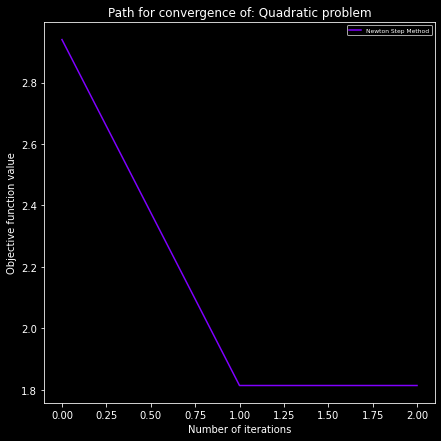

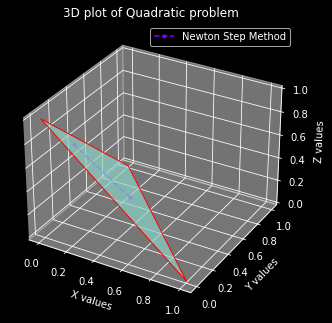

In [63]:
plot_line_search("Quadratic problem",ls)

In [64]:

lp = Linear_Quadratic_Function(q1=[1, 1])
lp_ineq1 = Linear_Quadratic_Function(q1=[-1, -1], q0=1)  # y >= -x + 1
lp_ineq2 = Linear_Quadratic_Function(q1=[0, 1], q0=-1)  # y <= 1
lp_ineq3 = Linear_Quadratic_Function(q1=[1, 0], q0=-2)  # x <= 2
lp_ineq4 = Linear_Quadratic_Function(q1=[0, -1], q0=0)  # y >= 0
ls1 = LineSearch(verbose=True)
res = ls.interior_pt(func=lp, x0=(0.5, 0.75), is_minimize=False,ineq_constraints=[lp_ineq1, lp_ineq2, lp_ineq3, lp_ineq4],print_every=1)
print(res, flush=True)




Iter[0]: objective=-1.25 location: [0.5  0.75]
Iter[5]: objective=-0.13167093740908564 location: [1.46301542 0.69674043]
Optimization reached the target of objective function.
Iter[1]: objective=-2.1597557552302424 location: [1.46301532 0.69674044]
Optimization reached the target of objective function.
Optimization reached the target of objective function.
{'objective': 2.1597557552302424, 'success': True, 'num_iter': 1, 'final_mu': None, 'dim': 2, 'location': array([1.46301532, 0.69674044]), 'max_norm_location': 1.6204508814303147, 'min_objective_value': 1.25, 'max_objective_value': 2.1597557552302424, 'Equality constraints values': [], 'Equality constraints: Total Norm (Ax-b)': 0, 'Inequality constraints values': [-1.1597557552302424, -0.3032595637836586, -0.5369846809860992, -0.6967404362163414]}
{'objective': 2.1597557552302424, 'success': True, 'num_iter': 1, 'final_mu': None, 'dim': 2, 'location': array([1.46301532, 0.69674044]), 'max_norm_location': 1.6204508814303147, 'min_obje

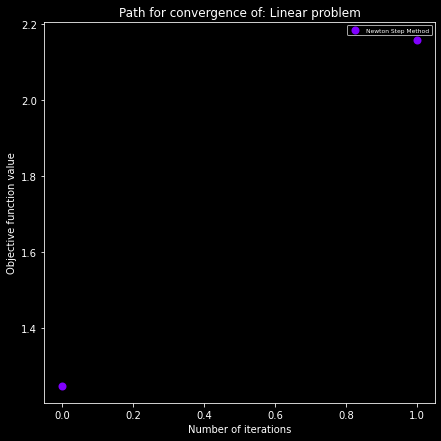

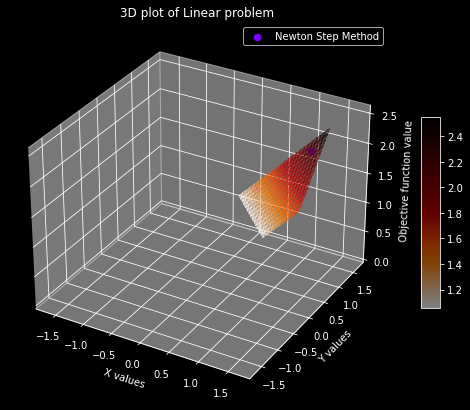

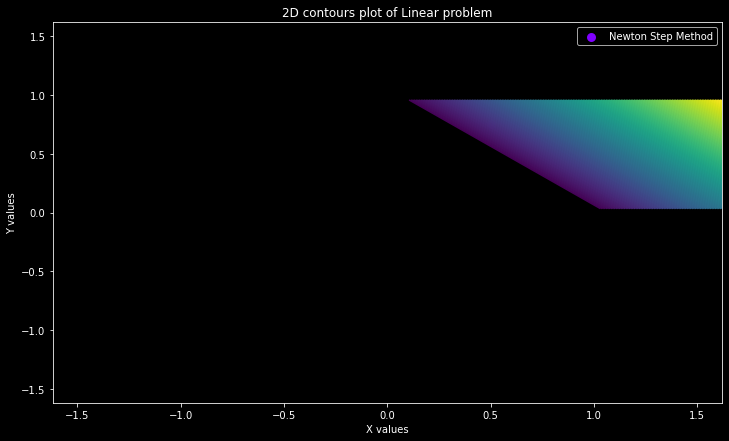

In [66]:
plot_line_search("Linear problem",ls)